In [1]:
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pandahouse
from read_db.CH import Getch


In [2]:
data = Getch(''' SELECT exp_group, 
                        user_id,
                        sum(action = 'like') likes,
                        sum(action = 'view') views,
                        likes/views ctr
                FROM simulator_20220320.feed_actions 
                WHERE toDate(time) between '2022-03-15' and '2022-03-21'
                        and exp_group in (1,2)
                GROUP BY exp_group, user_id
''').df 

In [3]:
data.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750


In [4]:
data.groupby('exp_group').count()


,user_id,likes,views,ctr
exp_group,,,,
1,10079,10079,10079,10079
2,9952,9952,9952,9952


In [5]:
data.groupby('exp_group').mean()


,user_id,likes,views,ctr
exp_group,,,,
1,75540.955948,13.792142,66.299831,0.215605
2,75142.800543,13.101387,66.148513,0.214419


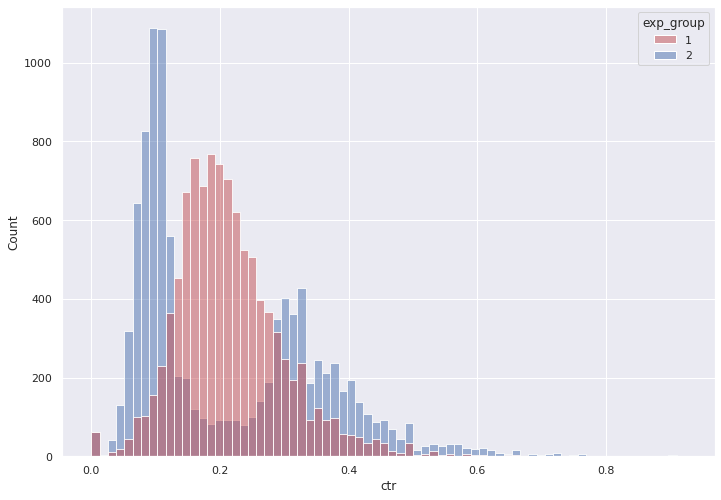

In [6]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = data, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

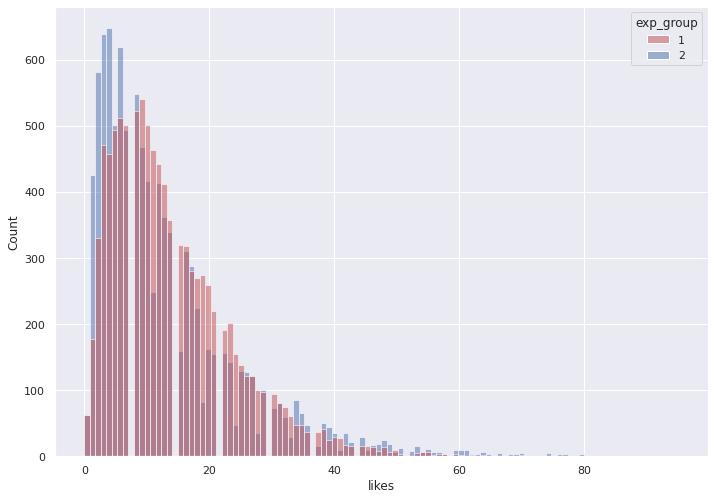

In [7]:
# исходя из полученных выше данныых мы видим, что тестовая группа и контрольная 
# отличаются немного по кол-ву участников, а также ctr значительным образом разнится
# посмотрим, что у нас с лайками 

sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = data, 
              x='likes', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

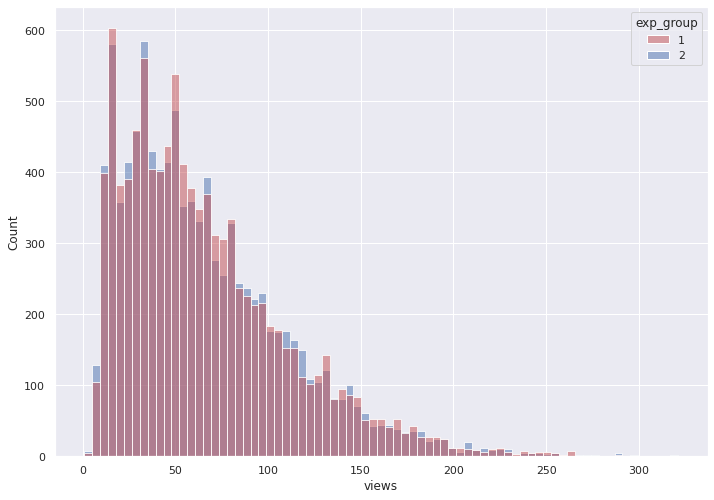

In [8]:
# сравним группы по просмотрам 

groups = sns.histplot(data = data, 
              x='views', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [11]:
# мы видим, что группы схожи по просмотрам, однако отличаются по кол-ву лайков. 


In [15]:
# попробуем применить t-test и сглаживание CTR 

def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [16]:
global_ctr_1 = data[data.exp_group == 1].likes.sum() / data[data.exp_group == 2].views.sum()
global_ctr_2 = data[data.exp_group == 2].likes.sum() / data[data.exp_group == 1].views.sum()         

In [17]:
data['smothed_ctr_1'] = data.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)


data['smothed_ctr_2'] = data.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

<AxesSubplot:xlabel='smothed_ctr_1'>

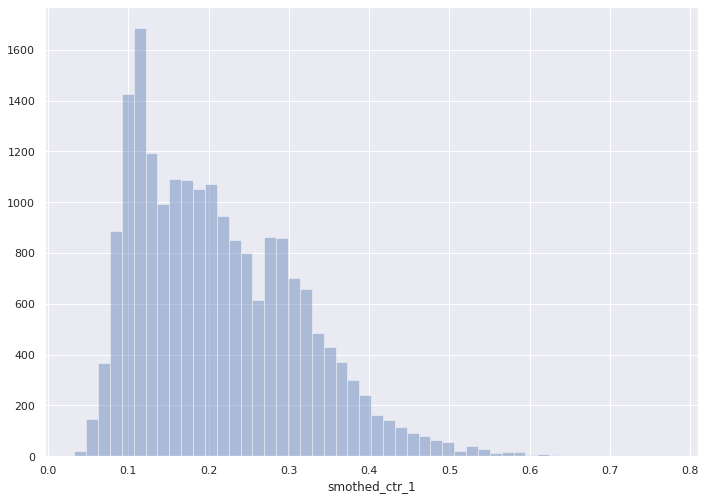

In [18]:
sns.distplot(data.smothed_ctr_1, 
             kde = False)

<AxesSubplot:xlabel='smothed_ctr_2'>

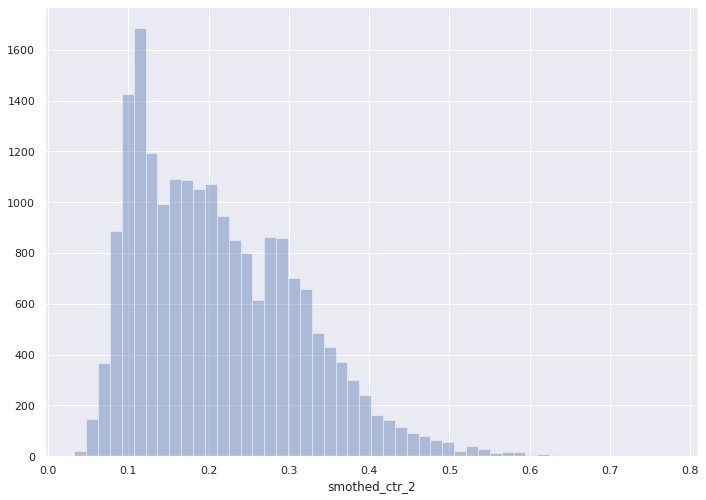

In [19]:
sns.distplot(data.smothed_ctr_2, 
             kde = False)

In [21]:
# t-test на ctr без сглаживания 

stats.ttest_ind(data[data.exp_group == 1].ctr,
                data[data.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.7094392041270486, pvalue=0.4780623130874935)

In [25]:
# t-test на сглаженном ctr

stats.ttest_ind(data[data.exp_group == 1].smothed_ctr_1,
                data[data.exp_group == 2].smothed_ctr_2,
                equal_var=False)

Ttest_indResult(statistic=1.535421954574943, pvalue=0.12470025846939371)

In [26]:
# проведем также тест Манна-Уитни

stats.mannwhitneyu(data[data.exp_group == 1].ctr,
                   data[data.exp_group == 2].ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

In [27]:
stats.mannwhitneyu(data[data.exp_group == 1].smothed_ctr_1,
                   data[data.exp_group == 2].smothed_ctr_2, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=56714366.0, pvalue=7.351788307393022e-58)

In [40]:
# мы видим, что на сглаженных данных p-value в t-test имеет более низкое значение, но 
# при этом показывает статистически значимые различия 

# тест Манна-уитни также говорит о том, что различия есть 

In [32]:
# проведем тест Манна-Уитни и t-test поверх бакетного преобразования

df = Getch(''' SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM simulator_20220320.feed_actions 
    WHERE toDate(time) between '2022-03-15' and '2022-03-21'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
''').df

In [34]:
# больше, чем 0.05
stats.mannwhitneyu(df[df.exp_group == 1].bucket_ctr, 
                   df[df.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

In [36]:
stats.ttest_ind(df[df.exp_group == 1].bucket_ctr, 
                   df[df.exp_group == 2].bucket_ctr, 
                   equal_var = False)

Ttest_indResult(statistic=5.668234732053979, pvalue=3.4455951649945907e-07)

<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

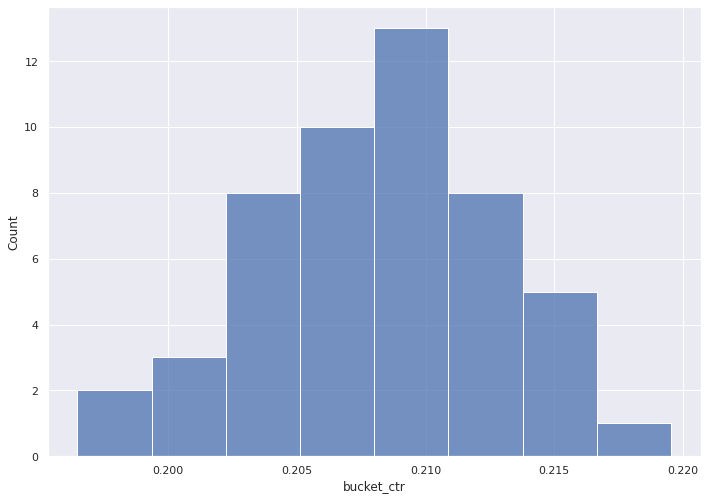

In [38]:
# схоже с нормальным распределением

sns.histplot(df[df.exp_group == 1].bucket_ctr)

<AxesSubplot:xlabel='ctr9', ylabel='Count'>

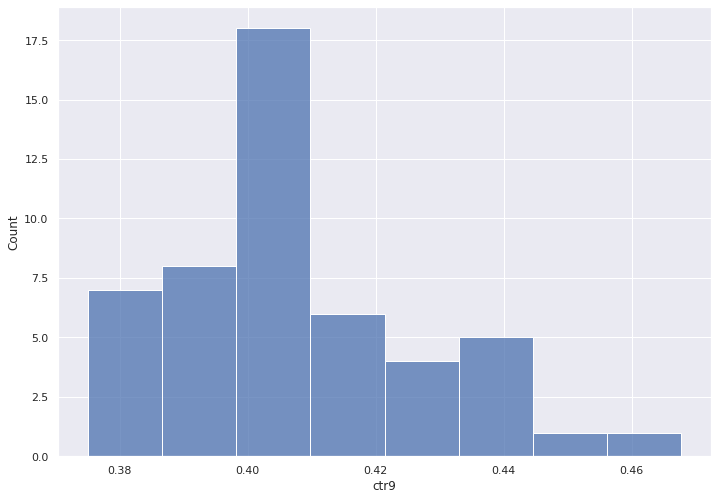

In [39]:
sns.histplot(df[df.exp_group == 2].ctr9)



In [41]:
# выводы:
# все тесты показали статически значимые различия, однако наблюдается разница в распределении
# я бы не стала раскатывать на всех пользователей новый алгоритм, а лучше изучила бы тестовую 
# группу. Есть подозрение, что не все пользователи одинаково реагируют - возможно, что там 
# есть какая-то закономернсть 